### Búsqueda de hiper-parámetros
## Framework Optuna

Por último, vamos a hacer una búsqueda de hiperparámetros usando [Optuna](https://optuna.org/). Como vimos en clase, Optuna es un framework que nos permite realizar búsqueda de hiperparámetros de forma más eficiente, y pensado tanto para funcionar de local con nuestra PC en una notebook, como para ser ejecutado en clusters o en la nube.

In [1]:
import optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
default_df = pd.read_csv("./datasets/Default.csv")

default_df["default"] = default_df["default"].apply(lambda x: 1 if x == "Yes" else 0)
default_df["student"] = default_df["student"].apply(lambda x: 1 if x == "Yes" else 0)

# como siempre vamos separando nuestras variables predictoras de la variable a predecir
X = default_df.loc[:, ["balance", "income", "student"]].values
y = default_df.loc[:, "default"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train) 
X_test = sc_X.transform(X_test)

Creemos la función que nos va a permitir evaluar las diferentes combinaciones de hiperparámetros en Optuna:

In [3]:
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 1, 100)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    p = trial.suggest_float("p", 1.0, 100.0)
    
    classifier_knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    
    # Realizamos la validación cruzada
    score = cross_val_score(classifier_knn, X_train, y_train, cv=3, scoring='f1', n_jobs=-1)
    
    return score.mean()

In [4]:
def champion_callback(study, frozen_trial):
    """
    Mostramos menos información, sino es demasiado verboso
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [5]:
# Creamos un estudio de Optuna
# Optuna es un poco verboso, dejamos que solo nos muestre logs de errores
optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, callbacks=[champion_callback])

Initial trial 0 achieved value: 0.1508834044916519
Trial 1 achieved value: 0.34499892528925447 with  56.2655% improvement
Trial 2 achieved value: 0.3608620815937889 with  4.3959% improvement
Trial 6 achieved value: 0.3846368056894372 with  6.1811% improvement
Trial 22 achieved value: 0.39680723317086947 with  3.0671% improvement
Trial 53 achieved value: 0.40603530534351145 with  2.2727% improvement


In [6]:
# Obtenemos los mejores hiper-parámetros encontrados
best_params = study.best_params
best_params

{'n_neighbors': 10, 'weights': 'distance', 'p': 90.36552154077324}

In [7]:
# Creamos el clasificador KNeighborsClassifier con los mejores hiperparámetros
classifier_knn_optuna = KNeighborsClassifier(**best_params)
# Entrenamos el clasificador con los datos de entrenamiento
classifier_knn_optuna.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10, p=90.36552154077324, weights='distance')

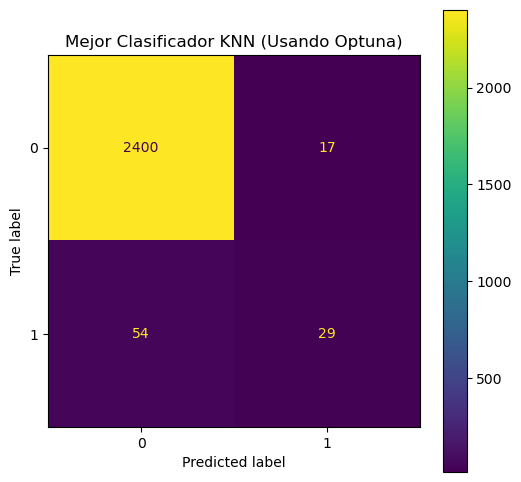

In [8]:
#Evaluamos
y_pred  = classifier_knn_optuna.predict(X_test)

cm_best_knn_optuna = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_knn_optuna,
                              display_labels=classifier_knn_optuna.classes_)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Mejor Clasificador KNN (Usando Optuna)");

In [9]:
# Midamos varias métricas:
print("Mejor Clasificador KNN (Usando Optuna)")
P = np.sum(cm_best_knn_optuna[1, :])
N = np.sum(cm_best_knn_optuna[0, :])
TP = cm_best_knn_optuna[1, 1]
TN = cm_best_knn_optuna[0, 0]
TPR = TP/P
TNR = TN/N
print(f"Sensibilidad: {TP/P}")
print(f"Especifixcidad: {TN/N}")
print(f"Exactitud balanceada: {(TPR + TNR)/2}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0)}")
print(f"Recuperación: {recall_score(y_test, y_pred, zero_division=0)}")
print(f"F1-score: {f1_score(y_test, y_pred, zero_division=0)}")

Mejor Clasificador KNN (Usando Optuna)
Sensibilidad: 0.3493975903614458
Especifixcidad: 0.9929664873810509
Exactitud balanceada: 0.6711820388712484
Precision: 0.6304347826086957
Recuperación: 0.3493975903614458
F1-score: 0.4496124031007752


---
Este resultado puede variar con cada ejecución. Para este modelo en particular, dado los pocos hiper-parámetros, es mejor usar la búsqueda por grilla directamente, pero en modelos más grandes (Deep Learning, o en ensambles), el rol de aplicar Optuna toma más importancia. Principalmente porque lo podemos llevar a clusters o a la nube para hacer búsquedas más poderosas.